In [1]:
import re

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '../../data/'

with open(f'{DATA_DIR}disclosures.pkl', 'rb') as file:
    disclosures = pickle.load(file)

with open(f'{DATA_DIR}clean/misconduct_indicators_train.pkl', 'rb') as file:
    misconduct_train = pickle.load(file)

# with open(f'{DATA_DIR}clean/misconduct_test.pkl', 'rb') as file:
#     disclosures = pickle.load(file)


In [3]:
def normalize_company_name(name):
    if not name:
        return None
    return re.sub('[^a-zA-Z]+', '', name).lower()


In [4]:
disclosures['normal_organization_name'] = disclosures['organization_name'].apply(normalize_company_name)
disclosures['normal_client_name'] = disclosures['client_name'].apply(normalize_company_name)
misconduct_train['normal_contractor_s'] = misconduct_train['contractor_s'].apply(normalize_company_name)

In [5]:
lobbyists_per_clientage = (
    disclosures
    .groupby(['normal_organization_name', 'normal_client_name'])
    .agg({'lobbyists': 'mean'})
).reset_index()

lobbyists_per_clientage[:4]

,normal_organization_name,normal_client_name,lobbyists
0,aanp,aanp,1.0
1,aarcorp,aarcorp,1.0
2,aaronlopez,mediscainc,1.0
3,aaronlopez,pinepharmaceuticals,1.0


In [6]:
lobbyist_features = (
    lobbyists_per_clientage
    .groupby('normal_client_name')
    .agg({
        'normal_organization_name': 'count',
        'lobbyists': 'sum'
    })
)

lobbyist_features.columns = ['lobbying_firms', 'lobbyists']
lobbyist_features['has_lobbyist'] = True


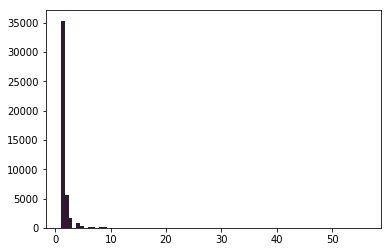

In [7]:
plt.hist(
    lobbyist_features.lobbying_firms,
    bins=80,
    color='#301830',
);

In [8]:
len(
    misconduct_train.join(
        lobbyist_features,
        on='normal_contractor_s'
    ).normal_contractor_s.unique()
)

207

In [9]:
misconduct_with_lobbying = misconduct_train.join(
    lobbyist_features,
    on='normal_contractor_s'
)

In [10]:
misconduct_with_lobbying.has_lobbyist = misconduct_with_lobbying.has_lobbyist.replace(np.nan, False)
misconduct_with_lobbying.lobbying_firms = misconduct_with_lobbying.lobbying_firms.replace(np.nan, 0).astype(int)
misconduct_with_lobbying.lobbyists = misconduct_with_lobbying.lobbyists.replace(np.nan, 0)


In [19]:
# misconduct_with_lobbying

misconduct_with_lobbying.loc[
    [
        740,
        854,
        1569,
        1616,
        1639,
        2217
    ],
    [
        'instance',
        'lobbying_firms',
        'lobbyists',
        'has_lobbyist'
    ]
]

,instance,lobbying_firms,lobbyists,has_lobbyist
740,Leavenworth Detention Center Contract Audit,7,47.0,True
854,Clean Air Act Violations at XTO Energy's Fort ...,5,30.0,True
1569,Inadequate Number of Anesthesiologists in Texas,2,14.0,True
1616,Safety Violation at Derby Facility,0,0.0,False
1639,Evolved Expendable Launch Vehicle Program Qual...,0,0.0,False
2217,Rigging Bids on Department of Defense Fuel Sup...,0,0.0,False


In [ ]:
# lobbyist rows correct at this point (before transforming to Bernoulli)

In [ ]:
misconduct_with_lobbying.has_lobbyist = misconduct_with_lobbying.has_lobbyist.replace(np.nan, False).astype(int)

In [ ]:
with open(f'{DATA_DIR}clean/misconduct_lobbying_indicators_train.pkl', 'wb') as file:
    pickle.dump(misconduct_with_lobbying, file)